In [41]:
# ==============================
# Standard Library Imports
# ==============================
from enum import Enum
import random

# ==============================
# Third-party Library Imports
# ==============================
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from matplotlib.ticker import MultipleLocator
import numpy as np  # Original numpy
import pennylane as qml
import torch 

# ==============================
# User defined 
# ==============================
import plot_data as pt
import torch_optimizer as tr_opt

In [42]:
# ==============================
# Setup for Quantum Computations
# ==============================

# PennyLane settings
dev = qml.device('default.mixed', wires=4)

# Define Hamiltonian for quantum computations
H = qml.Hamiltonian(
    coeffs=[-0.5, -0.5, -0.5, -0.5, -0.5, -0.5], 
    observables=[
        qml.PauliZ(0) @ qml.PauliZ(1) @ qml.Identity(2) @ qml.Identity(3),
        qml.PauliZ(0) @ qml.Identity(1) @ qml.PauliZ(2) @ qml.Identity(3),
        qml.PauliZ(0) @ qml.Identity(1) @ qml.Identity(2) @ qml.PauliZ(3),
        qml.Identity(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.Identity(3),
        qml.Identity(0) @ qml.PauliZ(1) @ qml.Identity(2) @ qml.PauliZ(3),
        qml.Identity(0) @ qml.Identity(1) @ qml.PauliZ(2) @ qml.PauliZ(3)
    ]
)

H_1 = qml.Hamiltonian(
    coeffs=[-0.5, -0.5, -0.5, -0.5], 
    observables=[
        qml.PauliZ(0), qml.PauliZ(1), qml.PauliZ(2), qml.PauliZ(3)
    ]
)

## New Hamiltonian

#### Entangler Hamiltonian

$$
H = 
-0.5 \cdot(
 \, Z_0 \otimes Z_1 \otimes I_{2} \otimes I_3
 + \, Z_{0} \otimes I_1 \otimes Z_{2} \otimes I_3
 + \, I_{0} \otimes Z_1 \otimes Z_{2} \otimes I_{3} \\
 + \, I_{0} \otimes Z_1 \otimes I_{2} \otimes Z_3
 + \, I_{0} \otimes I_1 \otimes Z_{2} \otimes Z_3 
)
$$


$$
where,
Z = \begin{pmatrix} 
1 & 0 \\ 
0 & -1 
\end{pmatrix}
$$

#### Entangler Hamiltonian_2

$$
H = 
-0.5 \cdot (
 \, Z_0 \otimes Z_1 \otimes I_{2} \otimes I_3
 + \, Z_{0} \otimes I_1 \otimes Z_{2} \otimes I_3
 + \, Z_{0} \otimes I_1 \otimes I_{2} \otimes Z_3\\
 + \, I_{0} \otimes Z_1 \otimes Z_{2} \otimes I_{3} 
 + \, I_{0} \otimes Z_1 \otimes I_{2} \otimes Z_3
 + \, I_{0} \otimes I_1 \otimes Z_{2} \otimes Z_3 
)
$$


$$
where,
Z = \begin{pmatrix} 
1 & 0 \\ 
0 & -1 
\end{pmatrix}
$$

#### Phase Accumulator Hamiltonian


$$
H_{1} = -0.5 \cdot (
    Z_0 + Z_1 + Z_2 + Z_3
) 
$$



$$

$$


$$
where,
Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}
$$

In [43]:
# Global Parameters
Tau_global = torch.tensor(0, dtype=torch.float, requires_grad=False)   # Dephase tau
Gamma_ps_global = torch.tensor(0, dtype=torch.float, requires_grad=False)
Paras_global = torch.tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.float, requires_grad=True)
Phi_global = torch.tensor(0, dtype=torch.float, requires_grad=True)

def Dephase_factor(tau):
    """ 
    Calculate the dephasing factor for a given dephasing time tau.

    Args:
        tau (torch.Tensor): Dephasing time.

    Returns:
        torch.Tensor: Dephasing factor.
    """  
    return 1 - torch.exp(-2 * tau)

$$
Let, e^{-t/T_2} = e^{-\tau} \\[1em]

\frac{1}{2} 

\begin{bmatrix}

1 & e^{(i\phi - \tau)} \\
e^{(-i\phi - \tau)} & 1

\end{bmatrix}

=

\frac{1}{2} 

\begin{bmatrix}

1 & e^{i\phi} \sqrt{1 - \gamma} \\
e^{-i\phi} \sqrt{1 - \gamma} & 1

\end{bmatrix}
$$

$$
\\[1em]
Then,
\quad \gamma = 
1 - e^{-2 \tau}
$$

$$ 
e^{-\tau} = \sqrt{1 - \gamma}
$$

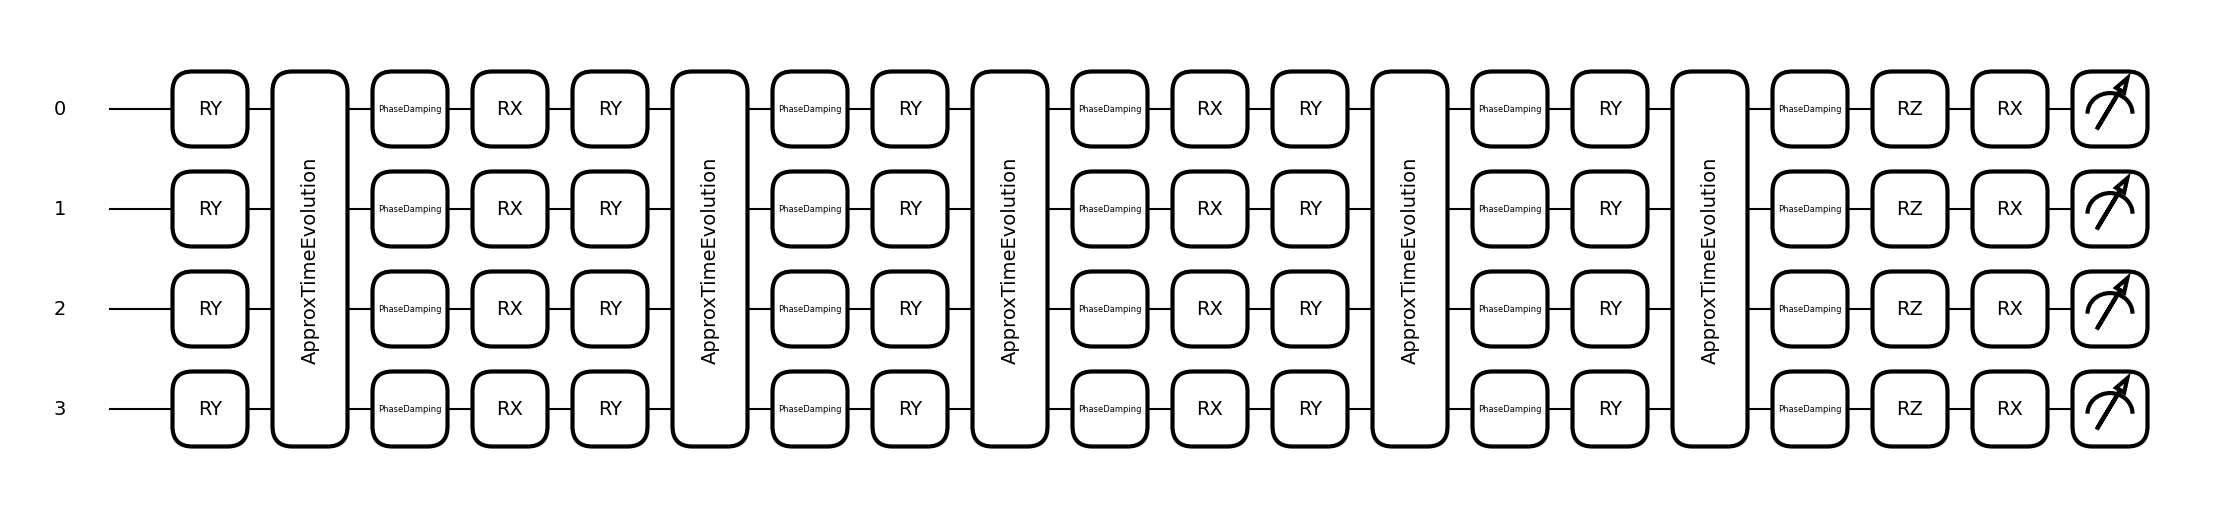

In [67]:
class INDEX(Enum):
    THETA_X1 = 0
    THETA_X2 = 1
    
    PHI_Z1 = 2
    PHI_Z2 = 3
    PHI_Z3 = 4
    PHI_Z4 = 5
    
    TAU_L1 = 6
    TAU_L2 = 7
    
    TAU_R1 = 8
    TAU_R2 = 9

@qml.qnode(dev, interface='torch', diff_method='backprop')
def circuit(phi):
    global Paras_global, Tau_global
    theta_x1 = 0.7259
    theta_x2 = 0.60505491
    
    phi_z1 = Paras_global[2]
    phi_z2 = Paras_global[3]
    phi_z3 = Paras_global[4]
    phi_z4 = Paras_global[5]
    
    tau_L1 = 1.486
    tau_L2 = 1.1560
    
    tau_R1 = 1.08127594
    tau_R2 = 1.41644359
    
    #  1.48653674', '1.15604317', '1.08127594', '1.41644359
    gamma_dephase = Dephase_factor(Tau_global)
    
    # Stage_1: RY for pi/2
    qml.RY(torch.pi/2, wires=0)
    qml.RY(torch.pi/2, wires=1)
    qml.RY(torch.pi/2, wires=2)
    qml.RY(torch.pi/2, wires=3)
    
    # Stage_2: Entangler_layer_1    
    qml.ApproxTimeEvolution(H, tau_L1, 1)
    qml.PhaseDamping(gamma_dephase, wires = 0)
    qml.PhaseDamping(gamma_dephase, wires = 1)    
    qml.PhaseDamping(gamma_dephase, wires = 2)    
    qml.PhaseDamping(gamma_dephase, wires = 3)    
    
    qml.RX(theta_x1, wires = 0)    
    qml.RX(theta_x1, wires = 1)    
    qml.RX(theta_x1, wires = 2)    
    qml.RX(theta_x1, wires = 3)    

    qml.RY(-torch.pi/2, wires = 0)    
    qml.RY(-torch.pi/2, wires = 1)   
    qml.RY(-torch.pi/2, wires = 2)   
    qml.RY(-torch.pi/2, wires = 3)   

    qml.ApproxTimeEvolution(H, tau_R1, 1)
    qml.PhaseDamping(gamma_dephase, wires = 0)
    qml.PhaseDamping(gamma_dephase, wires = 1) 
    qml.PhaseDamping(gamma_dephase, wires = 2) 
    qml.PhaseDamping(gamma_dephase, wires = 3) 
    
    qml.RY(torch.pi/2, wires = 0)    
    qml.RY(torch.pi/2, wires = 1) 
    qml.RY(torch.pi/2, wires = 2) 
    qml.RY(torch.pi/2, wires = 3) 
    
    # Stage_3: Entangler_layer_2    
    qml.ApproxTimeEvolution(H, tau_L2, 1)
    qml.PhaseDamping(gamma_dephase, wires = 0)
    qml.PhaseDamping(gamma_dephase, wires = 1)    
    qml.PhaseDamping(gamma_dephase, wires = 2)    
    qml.PhaseDamping(gamma_dephase, wires = 3)    
    
    qml.RX(theta_x2, wires = 0)    
    qml.RX(theta_x2, wires = 1)    
    qml.RX(theta_x2, wires = 2)    
    qml.RX(theta_x2, wires = 3)    

    qml.RY(-torch.pi/2, wires = 0)    
    qml.RY(-torch.pi/2, wires = 1)   
    qml.RY(-torch.pi/2, wires = 2)   
    qml.RY(-torch.pi/2, wires = 3)   

    qml.ApproxTimeEvolution(H, tau_R2, 1)
    qml.PhaseDamping(gamma_dephase, wires = 0)
    qml.PhaseDamping(gamma_dephase, wires = 1) 
    qml.PhaseDamping(gamma_dephase, wires = 2) 
    qml.PhaseDamping(gamma_dephase, wires = 3) 
    
    qml.RY(torch.pi/2, wires = 0)    
    qml.RY(torch.pi/2, wires = 1) 
    qml.RY(torch.pi/2, wires = 2) 
    qml.RY(torch.pi/2, wires = 3) 
    
    # Stage_4: Accumulator
    qml.ApproxTimeEvolution(H_1, phi, 1)
    qml.PhaseDamping(gamma_dephase, wires = 0)
    qml.PhaseDamping(gamma_dephase, wires = 1) 
    qml.PhaseDamping(gamma_dephase, wires = 2) 
    qml.PhaseDamping(gamma_dephase, wires = 3) 
    
    qml.RZ(phi_z1, wires=0)
    qml.RZ(phi_z2, wires=1)
    qml.RZ(phi_z3, wires=2)
    qml.RZ(phi_z4, wires=3)
    
    qml.RX(torch.pi/(2), wires=0)
    qml.RX(torch.pi/(2), wires=1)
    qml.RX(torch.pi/(2), wires=2)
    qml.RX(torch.pi/(2), wires=3)
    
    # return qml.state()
    return qml.density_matrix(wires = [0, 1, 2, 3])

fig, ax = qml.draw_mpl(circuit)(np.pi)

In [47]:
@qml.qnode(dev, interface = 'torch', diff_method = 'backprop')
def Post_selection(phi):

    global Paras_global, Gamma_ps_global
    get_density_matrix = circuit(phi)   # 16*16 for 4-qubit

    K = torch.tensor([
        [torch.sqrt(1 - Gamma_ps_global), 0], 
        [0, 1]
    ], dtype=torch.complex128)  # 2*2
    K_2 = torch.kron(K, K)      # 4*4
    K_3 = torch.kron(K, K_2)    # 8*8
    
    I_2 = torch.eye(2)            # 2*2
    
    # num_1 = torch.kron(K_3, I_2) @ get_density_matrix @ torch.kron(K_3, I_2).conj().T
    # num_2 = torch.kron(I_2, K_3) @ get_density_matrix @ torch.kron(I_2, K_3).conj().T
    
    # den_1 = 2*torch.trace(num_1)
    # den_2 = 2*torch.trace(num_2)
    
    # rho_1 = num_1 / den_1
    # rho_2 = num_2 / den_2
    
    # rho_ps = rho_1 + rho_2
    
    num = torch.kron(K, K_3) @ get_density_matrix @ torch.kron(K, K_3).conj().T
    den = torch.trace(num)
    
    rho_ps = num / den
        
    qml.QubitDensityMatrix(rho_ps, wires = [0, 1, 2, 3])
    
    return qml.density_matrix(wires = [0, 1, 2, 3])  

#### Expand for 4-qubit: [16*16] 

#### Independently

$$
\rho_{ps} =

\frac
{(K_3 \otimes I_2) \rho (K_3 \otimes I_2)^{\dagger}}
{2Tr[K_3 \otimes I_2) \rho (K_3 \otimes I_2)^{\dagger}]}

+

\frac
{(I_2 \otimes K_3) \rho (I_2 \otimes K_3)^{\dagger}}
{2Tr[(I_2 \otimes K_3) \rho (I_2 \otimes K_3)^{\dagger}]}
$$

$$ 
where,
K =  \begin{bmatrix}
\sqrt{1-\gamma_{ps}} & 0 \\
0 & 1 
\end{bmatrix}  
, K_2 =  (K \otimes K)
\
and
\
K_3 =  (K \otimes K_2)
$$





$$ 
I_2 =  
\begin{bmatrix}
1 & 0 \\
0 & 1 
\end{bmatrix}  
$$




#### Legacy

$$
\rho_{ps} =

\frac
{(K \otimes K_3) \rho (K \otimes K_3)^{\dagger}}
{Tr[(K \otimes K_3) \rho (K \otimes K_3)^{\dagger}]}
$$

$$ 
where,
K =  \begin{bmatrix}
\sqrt{1-\gamma_{ps}} & 0 \\
0 & 1 
\end{bmatrix}  
, K_2 =  (K \otimes K)
\
and
\
K_3 =  (K \otimes K_2)
$$

In [49]:
def set_circuit(desired_tau_dephase, desired_gamma_post_selection):
    """
    Set the global dephasing rate and post-selection rate for the circuit.

    Args:
        desired_tau_dephase (float): Desired dephasing rate tau.
        desired_gamma_post_selection (float): Desired post-selection rate gamma.
    """
    global Tau_global, Gamma_ps_global 
    
    Tau_global = torch.tensor(desired_tau_dephase)
    Gamma_ps_global = torch.tensor([desired_gamma_post_selection])
    
def cost_function(paras):
    """ 
    Compute the cost using classical Fisher information for the given parameters.

    Args:
        paras (torch.Tensor): Parameters for quantum gates.

    Returns:
        torch.Tensor: Computed cost.
    """
    global Paras_global, Phi_global
    Paras_global = paras

    CFI = qml.qinfo.classical_fisher(Post_selection)(Phi_global)
    
    return -CFI

def sweep_cfi(sweep_range, initial_parameters):
    Phi = torch.arange(sweep_range[0], sweep_range[1], sweep_range[2], dtype=torch.float32)
    Data = torch.zeros((len(Phi), 2))
    Data[:,0] = Phi
    
    global Phi_global
    params_tensor = initial_parameters.clone().requires_grad_(True)
    
    for phi_idx in range(len(Phi)):
        Phi_global = Phi[phi_idx].clone().requires_grad_(True)
        
        Data[phi_idx, 1] = -cost_function(params_tensor)
        
    return Data

def sweep_by_tau(sweep_range, init_par, tau_dephase, gamma_post_selection):
    for tau_idx, tau_current in enumerate(tau_dephase):
        set_circuit(tau_current, gamma_post_selection)
        
        temp = sweep_cfi(sweep_range, init_par).detach().numpy()
        
        if tau_idx == 0:
            Data = np.zeros((len(tau_dephase), len(temp[:,0]), len(temp[0,:])))
            Data[tau_idx][:, :] = temp
        else:
            Data[tau_idx][:, :] = temp
        
    return Data

In [52]:
import time

def torch_optimization(sweep_range, initial_parameters, method):
    """ 
    Perform optimization using specified optimizer over a range of phi values.

    Args:
        sweep_range (list): Range of phi values for optimization.
        initial_parameters (torch.Tensor): Initial parameters for optimization.
        method (str): Optimization method ('LBFGS' or 'Adam').

    Returns:
        torch.Tensor: Data tensor containing optimization results.
    """
    Phi = torch.arange(sweep_range[0], sweep_range[1], sweep_range[2], dtype=torch.float32)
    Data = torch.zeros((len(Phi), len(initial_parameters) + 2))
    Data[:,0] = Phi
    
    global Phi_global
    params_tensor = initial_parameters.clone().requires_grad_(True)
    
    opt = tr_opt.select_optimizer(method, params_tensor)
    
    def closure():
        opt.zero_grad()
        loss = cost_function(params_tensor)
        loss.backward()
        return loss
       
    steps = 15
    f_logs = [cost_function(params_tensor).item()]
    ftol = 1e-10
        
    start_time = time.time()
    # Begin optimization
    for phi_idx in range(len(Phi)):
        Phi_global = Phi[phi_idx].clone().requires_grad_(True)

        for i in range(steps):
            opt.step(closure)

            fval = cost_function(opt.param_groups[0]['params'][0]).item()
            f_logs.append(fval)
            if np.abs((fval-f_logs[-2])/fval) < ftol:
                break
            
        elapsed_time = time.time() - start_time
        estimated_total_time = (elapsed_time / (phi_idx + 1)) * len(Phi)
        remaining_time = estimated_total_time - elapsed_time
        
        formatted_x = [f"{x:.8f}" for x in opt.param_groups[0]['params'][0].detach().numpy()]
        
        del_CFI = (Data[phi_idx-1, 1]) + fval if phi_idx > 0 else 0
        print(
            "CFI =", f"{-fval:.5f}", 
            "Paras =", formatted_x, 
            f"[eta : {remaining_time / 60:.2f}_min,",
            f"iter_left : {len(Phi) - phi_idx},", 
            f"del_CFI : {del_CFI:.2f}]"
        )

        Data[phi_idx, 1] = -fval
        Data[phi_idx, 2:] = opt.param_groups[0]['params'][0]        
        
    return Data

In [53]:
def optimization_by_tau(sweep_range, init_par, tau_dephase, gamma_post_selection, method):
    """ 
    Iterate over different values of tau_dephase and gamma_post_selection for optimization.

    Args:
        sweep_range (list): Range of phi values for optimization.
        init_par (torch.Tensor): Initial parameters for optimization.
        tau_dephase (list): List of dephasing rates tau to iterate over.
        gamma_post_selection (float): Post-selection rate gamma.
        method (str): Optimization method.

    Returns:
        np.ndarray: Numpy array with optimization results for each tau.
    """
    for tau_idx, tau_current in enumerate(tau_dephase):
        set_circuit(tau_current, gamma_post_selection)
        
        temp = torch_optimization(sweep_range, init_par, method).detach().cpu().numpy()
        if tau_idx == 0:
            Data = np.zeros((len(tau_dephase), len(temp[:,0]), len(temp[0,:])))
            Data[tau_idx][:, :] = temp
        else:
            Data[tau_idx][:, :] = temp
            
    return Data

In [54]:

sweep_range = torch.tensor(
    [1e-2, 2*torch.pi, 3e-3], 
    dtype=torch.float, requires_grad=False
)

init_par = torch.tensor([
    # theta_x1:x2
    0.72, 0.60,
    
    # phi_z1:z4
    1.4, 1.4, 1.4, 1.4, 
    
    # tau_L1:L2
    1.48653674,1.15604317,
    
    # tau_R1:R2
    1.0812, 1.41644
    ], dtype=torch.float)


tau_dephase = 0,
gamma_ps = 0.8

start_time = time.time()
res = optimization_by_tau(sweep_range, init_par, tau_dephase, gamma_ps, 'LBFGS')
end_time = time.time()

running_time = (end_time - start_time) / 60

CFI = 33.67015 Paras = ['0.72000003', '0.60000002', '1.57806885', '1.57807016', '1.57807016', '1.57807016', '1.48653674', '1.15604317', '1.08120000', '1.41644001'] [eta : 180.48_min, iter_left : 2092, del_CFI : 0.00]
CFI = 33.67068 Paras = ['0.72000003', '0.60000002', '1.58258963', '1.58252621', '1.58268714', '1.58268714', '1.48653674', '1.15604317', '1.08120000', '1.41644001'] [eta : 221.36_min, iter_left : 2091, del_CFI : -0.00]
CFI = 33.67070 Paras = ['0.72000003', '0.60000002', '1.58572829', '1.58518207', '1.58611524', '1.58611524', '1.48653674', '1.15604317', '1.08120000', '1.41644001'] [eta : 218.77_min, iter_left : 2090, del_CFI : -0.00]
CFI = 33.67055 Paras = ['0.72000003', '0.60000002', '1.58754921', '1.58688855', '1.58928406', '1.58928406', '1.48653674', '1.15604317', '1.08120000', '1.41644001'] [eta : 208.55_min, iter_left : 2089, del_CFI : 0.00]
CFI = 33.67050 Paras = ['0.72000003', '0.60000002', '1.58996844', '1.58951497', '1.59263909', '1.59263909', '1.48653674', '1.15604

In [55]:
np.save(f"result_[{tau_dephase[0]}]_{running_time:.2f}", res)

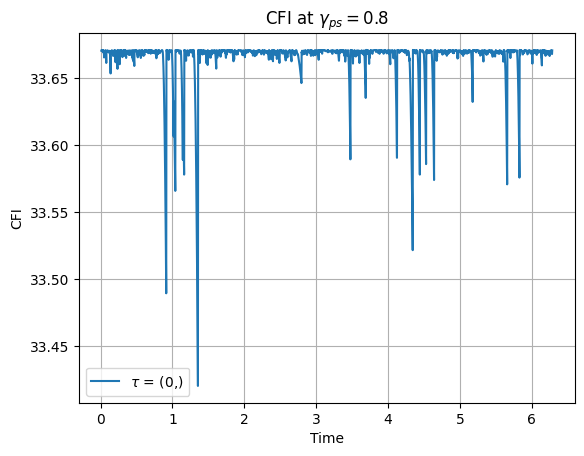

In [56]:
plt.plot(res[0][:,0], res[0][:,1], label = f'$\\tau$ = {tau_dephase}')
plt.title(f'CFI at $\gamma_{{ps}} = {gamma_ps}$')
plt.xlabel('Time')
plt.ylabel('CFI')
plt.grid()
plt.legend()
plt.show()

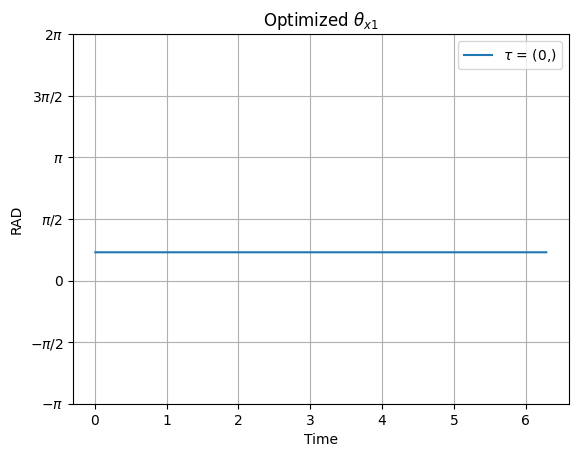

In [57]:
plt.plot(res[0][:,0], res[0][:,INDEX.THETA_X1.value + 2], label = f'$\\tau$ = {tau_dephase}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
# plt.ylim(-np.pi/2, np.pi/2)
plt.title(f'Optimized $\\theta_{{x1}}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()

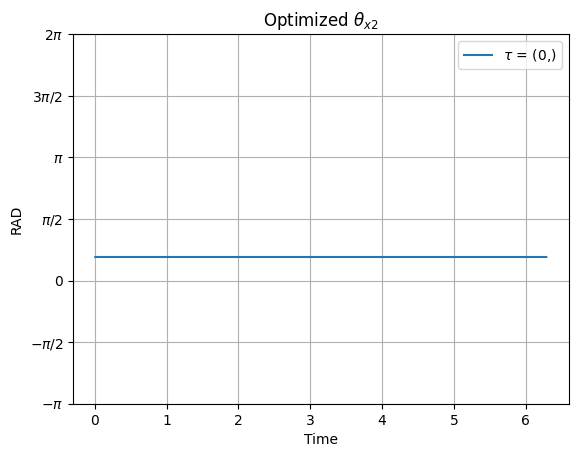

In [58]:
plt.plot(res[0][:,0], res[0][:,INDEX.THETA_X2.value + 2], label = f'$\\tau$ = {tau_dephase}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
# plt.ylim(-np.pi/2, np.pi/2)
plt.title(f'Optimized $\\theta_{{x2}}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()

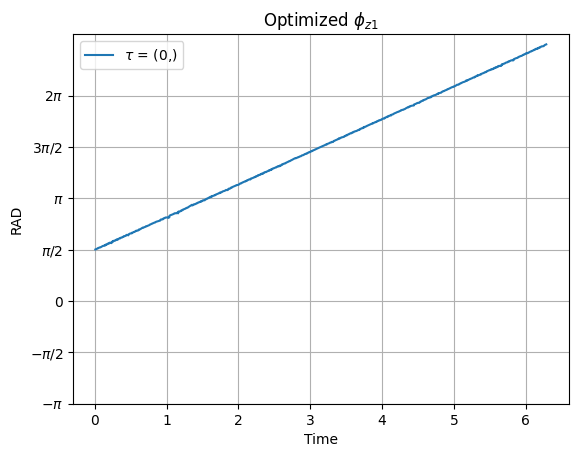

In [59]:
plt.plot(res[0][:,0], res[0][:,INDEX.PHI_Z1.value + 2], label = f'$\\tau$ = {tau_dephase}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
# plt.ylim(-np.pi/2, np.pi/2)
plt.title(f'Optimized $\\phi_{{z1}}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()

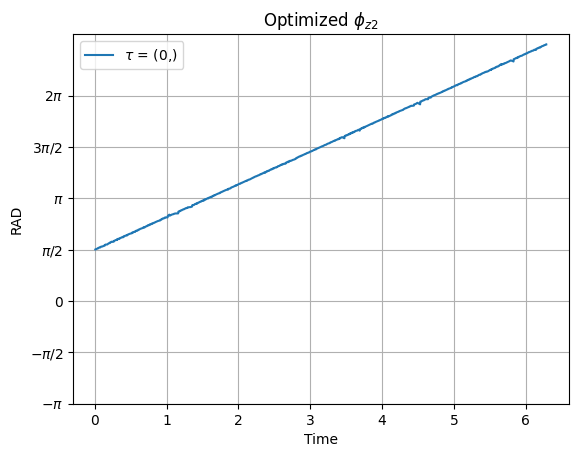

In [60]:
plt.plot(res[0][:,0], res[0][:,INDEX.PHI_Z2.value + 2], label = f'$\\tau$ = {tau_dephase}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
# plt.ylim(-np.pi/2, np.pi/2)
plt.title(f'Optimized $\\phi_{{z2}}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()

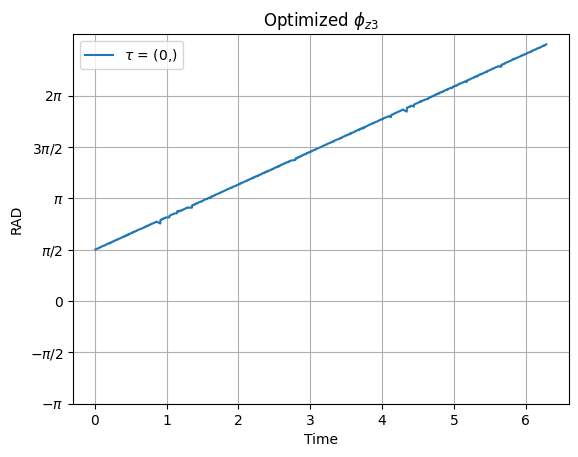

In [61]:
plt.plot(res[0][:,0], res[0][:,INDEX.PHI_Z3.value + 2], label = f'$\\tau$ = {tau_dephase}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
# plt.ylim(-np.pi/2, np.pi/2)
plt.title(f'Optimized $\\phi_{{z3}}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()

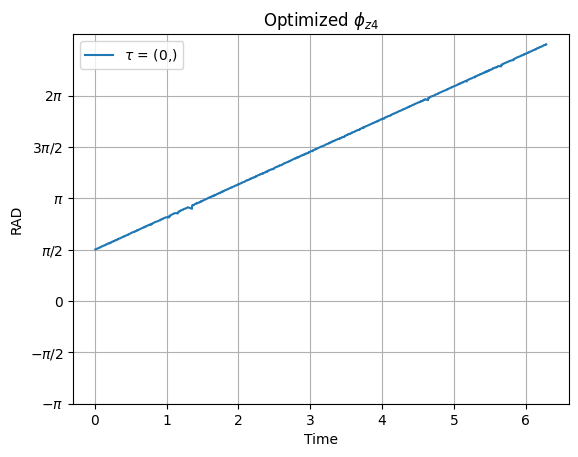

In [62]:
plt.plot(res[0][:,0], res[0][:,INDEX.PHI_Z4.value + 2], label = f'$\\tau$ = {tau_dephase}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
# plt.ylim(-np.pi/2, np.pi/2)
plt.title(f'Optimized $\\phi_{{z4}}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()

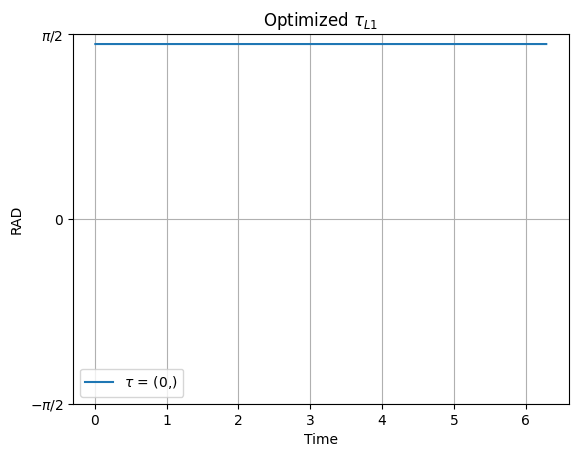

In [63]:
plt.plot(res[0][:,0], res[0][:,INDEX.TAU_L1.value + 2], label = f'$\\tau$ = {tau_dephase}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
plt.ylim(-np.pi/2, np.pi/2)
plt.title(f'Optimized $\\tau_{{L1}}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()

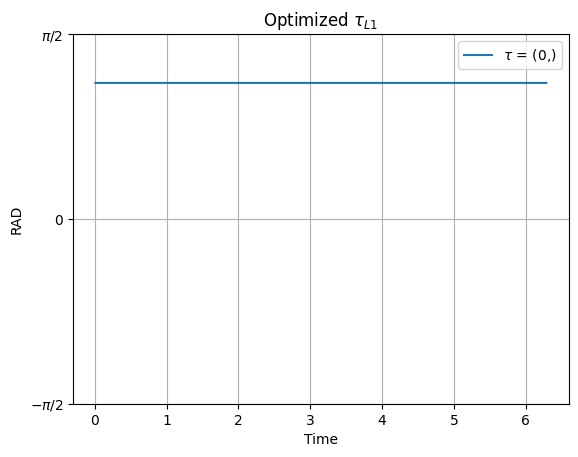

In [64]:
plt.plot(res[0][:,0], res[0][:,INDEX.TAU_L2.value + 2], label = f'$\\tau$ = {tau_dephase}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
plt.ylim(-np.pi/2, np.pi/2)
plt.title(f'Optimized $\\tau_{{L1}}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()

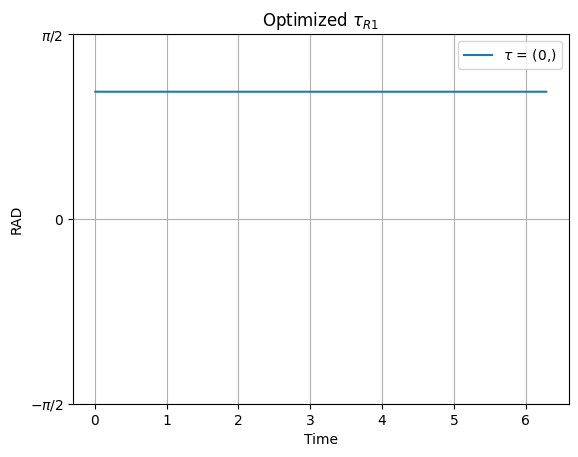

In [65]:
plt.plot(res[0][:,0], res[0][:,INDEX.TAU_R1.value + 2], label = f'$\\tau$ = {tau_dephase}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
plt.ylim(-np.pi/2, np.pi/2)
plt.title(f'Optimized $\\tau_{{R1}}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()

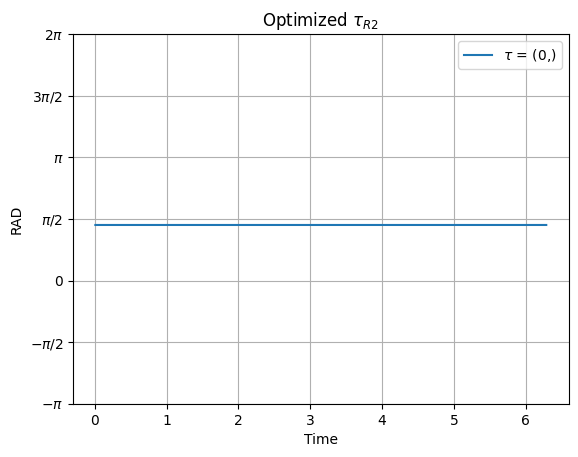

In [66]:
plt.plot(res[0][:,0], res[0][:,INDEX.TAU_R2.value + 2], label = f'$\\tau$ = {tau_dephase}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
# plt.ylim(-np.pi/2, np.pi/2)
plt.title(f'Optimized $\\tau_{{R2}}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()